In [1]:
import json
import re
import requests
import warnings

from adjustText import adjust_text
import geopandas as gpd
from matplotlib.lines import Line2D
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats
import seaborn as sns
from shapely.geometry import Point, Polygon, shape

warnings.filterwarnings("ignore")

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial']

EPSG = 4326

#### Functions for loading data

In [2]:
def name_to_var(name: str) -> str:
    """Converts a string into a standardized Python variable name for a DataFrame.

    Args:
        name (str): The input string, typically a file or resource name.

    Returns:
        str: The sanitized and formatted variable name.
    """
    name = re.sub(r'\.\w+$', '', name)
    name = re.sub(r'\W+', '_', name)
    return name.lower() + "_df_raw"


def load_ckan_data(package_id, filetype):
    """Loads data of a specific file type from a CKAN package into global DataFrames.

    Fetches the resource list for a given CKAN package ID from Toronto's Open
    Data portal. It then finds all resources matching the specified `filetype`,
    reads them into pandas DataFrames, and assigns them to variables in the
    global namespace.

    The variable names are generated from the resource names using the
    `name_to_var` helper function.

    Args:
        package_id (str): The unique identifier for the CKAN package.
        filetype (str): The desired file format to load, e.g., 'csv' or 'xlsx'.
    """
    url = "https://ckan0.cf.opendata.inter.prod-toronto.ca/api/3/action/package_show"
    res = requests.get(url, params={"id": package_id})
    res.raise_for_status()
    resources = res.json().get("result", {}).get("resources", [])

    print(f"\nPackage: {package_id}")
    for r in resources:
        if r["format"].lower() == filetype:
            df = pd.read_csv(r["url"]) if filetype == 'csv' else pd.read_excel(r["url"])
            var_name = name_to_var(r["name"])
            globals()[var_name] = df
            print(f"== {var_name} loaded ==")

#### Function for processing demographic data

In [3]:
relevant_columns = [
    'Neighbourhood Name',
    'Neighbourhood Number',
    'TSNS 2020 Designation',
    'Total - Age groups of the population - 25% sample data',
    '  0 to 14 years',
    '  15 to 64 years',
    '  65 years and over',
    '    Children',
    '      With children',
    '    One-parent-family households',
    '    Median total income in 2020  among recipients ($)',
    'Prevalence of low income based on the Low-income measure, after tax (LIM-AT) (%)'
]

rename_dict = {
    'Neighbourhood Number': 'AREA_SHORT_CODE',
    'TSNS 2020 Designation': 'TSNS',
    'Total - Age groups of the population - 25% sample data': 'Total Population',
    '  0 to 14 years': '0_14 years',
    '  15 to 64 years': '15_64 years',
    '  65 years and over': '65 years and over',
    '    Children': 'Children',
    '      With children': 'Couple families with children',
    '    One-parent-family households': 'One parent families',
    '    Median total income in 2020  among recipients ($)': 'Median total income',
    'Prevalence of low income based on the Low-income measure, after tax (LIM-AT) (%)': 'low income (%)'
}


def set_first_row_as_header(df: pd.DataFrame) -> pd.DataFrame:
    """Set the first row of a DataFrame as its header.

    Args:
      df: The input DataFrame whose first row should become the header.

    Returns:
      A new DataFrame with updated column headers and reset index.
    """
    new_header = df.iloc[0]
    df = df[1:]
    df.columns = new_header
    return df.reset_index(drop=True)


def demographics_df_process(
    raw_df: pd.DataFrame,
    relevant_columns: list[str]=relevant_columns,
    rename_dict: dict[str, str]=rename_dict
) -> pd.DataFrame:
    """Process the raw neighbourhood demographic DataFrame to extract and 
    standardize key columns.

    This function transposes the input DataFrame, sets the first row as the 
    header, selects the first occurrence of relevant columns, renames them 
    using a dictionary,
    and returns a cleaned version.

    Args:
      raw_df: The raw demographic DataFrame to process.
      relevant_columns: A list of column names to retain from the raw data.
      rename_dict: A dictionary mapping original column names to standardized names.

    Returns:
      A cleaned and processed demographic DataFrame with selected and renamed columns.
    """
    raw_df = raw_df.copy()
    df = raw_df.T.reset_index(names='Neighbourhood Name')
    df = set_first_row_as_header(df)
    first_occurrence = {}
    for idx, col in enumerate(df.columns):
        if col in relevant_columns and col not in first_occurrence:
            first_occurrence[col] = idx

    missing = [col for col in relevant_columns if col not in first_occurrence]
    if missing:
        print(f"Warning: missing columns: {missing}")

    col_indices = [
        first_occurrence[col]
        for col in relevant_columns if col in first_occurrence
    ]
    demographics_df = df.iloc[:, col_indices].copy()

    demographics_df.rename(columns=rename_dict, inplace=True)
    if 'TSNS' in demographics_df.columns:
        demographics_df['TSNS'] = demographics_df['TSNS'].replace(
            to_replace=r'Neighbourhood Improvement Area.*',
            value='Neighbourhood Improvement Area', regex=True
        )

    return demographics_df

#### Function for processing registered_program and drop_in data

In [4]:
def registered_program_process(registered_programs_df: pd.DataFrame) -> pd.DataFrame:
    """Clean and enrich registered programs data with date ranges and session counts.

    This function parses date ranges, handles missing age values,
    converts day names to weekdays, and calculates the number of sessions per program.

    Args:
      registered_programs_df: The raw DataFrame containing registered program data.

    Returns:
      A cleaned DataFrame with additional columns:
      'First Date', 'Last Date', 'days_of_the_week_set', and 'num_of_sessions'.
    """
    registered_programs_df = registered_programs_df.copy()
    date_split = registered_programs_df['From To'].str.split(' to ', expand=True)
    registered_programs_df['First Date'] = pd.to_datetime(date_split[0].str.strip(), format='%b-%d-%Y')
    registered_programs_df['Last Date'] = pd.to_datetime(date_split[1].str.strip(), format='%b-%d-%Y')
    registered_programs_df['Max Age'] = registered_programs_df['Max Age'].fillna(100)

    registered_programs_df['days_of_the_week_set'] = registered_programs_df['Days of The Week'].apply(
        lambda x: set(x.split(','))
    )
    day_name_to_weekday = {'Mon': 0, 'Tue': 1, 'Wed': 2, 'Thu': 3, 'Fri': 4, 'Sat': 5, 'Sun': 6}

    registered_programs_df['weekday_nums'] = registered_programs_df['days_of_the_week_set'].apply(
        lambda x: set(day_name_to_weekday[day.strip()] for day in x)
    )

    def count_sessions(row):
        date_range = pd.date_range(start=row['First Date'], end=row['Last Date'])
        return sum(d.weekday() in row['weekday_nums'] for d in date_range)

    registered_programs_df['num_of_sessions'] = registered_programs_df.apply(count_sessions, axis=1)

    registered_programs_df.drop(
    columns=['Days of The Week', 'From To', 'weekday_nums'],
    inplace=True
    )

    return registered_programs_df


def drop_in_process(drop_in_df: pd.DataFrame) -> pd.DataFrame:
    """Clean and process drop-in program data.

    This function fills missing age values, renames columns for consistency,
    converts date columns, and calculates the number of sessions.

    Args:
      drop_in_df: The raw DataFrame containing drop-in program data.

    Returns:
      A cleaned DataFrame with standardized age columns,
      parsed dates, and a 'num_of_sessions' column.
    """
    drop_in_df = drop_in_df.copy()
    drop_in_df['Age Max'] = drop_in_df['Age Max'].fillna(100)
    drop_in_df.rename(columns={'Age Max': 'Max Age'}, inplace=True)
    drop_in_df.rename(columns={'Age Min': 'Min Age'}, inplace=True)
    drop_in_df['First Date'] = pd.to_datetime(drop_in_df['First Date'])
    drop_in_df['Last Date'] = pd.to_datetime(drop_in_df['Last Date'])
    drop_in_df['num_of_sessions'] = (drop_in_df['Last Date'] - drop_in_df['First Date']).dt.days + 1
    return drop_in_df

#### Load the data

In [5]:
load_ckan_data("registered-programs-and-drop-in-courses-offering",'csv')
load_ckan_data("neighbourhood-profiles",'xlsx')
load_ckan_data('address-points-municipal-toronto-one-address-repository','csv')
load_ckan_data("neighbourhoods",'csv')


Package: registered-programs-and-drop-in-courses-offering
== locations_df_raw loaded ==
== drop_in_df_raw loaded ==
== registered_programs_df_raw loaded ==
== facilities_df_raw loaded ==

Package: neighbourhood-profiles
== neighbourhood_profiles_2021_158_model_df_raw loaded ==

Package: address-points-municipal-toronto-one-address-repository
== address_points_4326_df_raw loaded ==
== address_points_2952_df_raw loaded ==

Package: neighbourhoods
== neighbourhoods_4326_df_raw loaded ==
== neighbourhoods_2952_df_raw loaded ==
== neighbourhoods_historical_140_4326_df_raw loaded ==
== neighbourhoods_historical_140_2952_df_raw loaded ==


In [6]:
registered_program_df = registered_program_process(registered_programs_df_raw)

In [7]:
drop_in_df = drop_in_process(drop_in_df_raw)

In [8]:
demographics_df = demographics_df_process(neighbourhood_profiles_2021_158_model_df_raw)

In [9]:
locations_df = locations_df_raw.copy()
address_points_4326_df = address_points_4326_df_raw.copy()
neighbourhoods_4326_df = neighbourhoods_4326_df_raw.copy()

#### Merge Data

In [10]:
demographics_geo_df = pd.merge(demographics_df, neighbourhoods_4326_df, on='AREA_SHORT_CODE', how='outer')

In [11]:
demographics_geo_df.drop(['_id', 'AREA_ID', 'AREA_ATTR_ID', 'PARENT_AREA_ID', 'AREA_LONG_CODE',
       'AREA_NAME', 'AREA_DESC', 'CLASSIFICATION', 'CLASSIFICATION_CODE',
       'OBJECTID'], axis=1, inplace=True)

In [12]:
def parse_geometry(geom_string):
    return shape(json.loads(geom_string))


def normalize_address(address):
    address = address.upper().replace('.', '')
    address = address.replace(' LN', ' LANE')
    address = address.replace('BERNER TRL', 'BERNER TRAIL')
    address = address.replace(' CIR', ' CRCL')
    address = address.replace(' TERR', ' TER')
    address = address.replace(' PLACE RD', ' PL')
    address = address.replace('2955 DON MILLS RD W', '2955 DON MILLS RD')
    address = address.replace('105 COLBORNE LODGE DR W', '105 COLBORNE LODGE DR')
    return address


def create_full_address(row):
    parts = [
        row['Street No'],
        row['Street Name'],
        row['Street Type'],
        row['Street Direction']
    ]
    string_parts = [str(part).strip() for part in parts if pd.notna(part) and str(part).strip()]
    return normalize_address(' '.join(string_parts))


def make_programs_with_coords_df(
    all_programs_df: pd.DataFrame,
    locations_df: pd.DataFrame,
    address_points_4326_df_: pd.DataFrame
) -> pd.DataFrame:
    """Merge program data with location and coordinate information.

    This function creates full addresses, normalizes them,
    joins with spatial address data, and assigns geometries to programs.

    Args:
      all_programs_df: DataFrame containing all program records.
      locations_df: DataFrame containing location metadata for each program.
      address_points_4326_df_: DataFrame of normalized addresses with spatial geometry.

    Returns:
      A DataFrame of programs with assigned geometry coordinates,
      excluding those without valid spatial matches.
    """
    address_points_4326_df = address_points_4326_df_.copy()
    programs_with_locations_df = pd.merge(all_programs_df, locations_df, on='Location ID', how='left')
    programs_with_locations_df['ADDRESS_FULL'] = programs_with_locations_df.apply(create_full_address, axis=1)
    address_points_4326_df['ADDRESS_FULL'] = address_points_4326_df['ADDRESS_FULL'].apply(normalize_address)
    address_geom_df = address_points_4326_df[['ADDRESS_FULL', 'geometry']].copy()

    programs_with_coords_df = all_programs_df.copy()
    programs_with_coords_df['ADDRESS_FULL'] = programs_with_locations_df['ADDRESS_FULL']
    
    programs_with_coords_df = pd.merge(programs_with_coords_df, address_geom_df, on='ADDRESS_FULL', how='left')
    num_no_coord = programs_with_coords_df[programs_with_coords_df['geometry'].isna()].shape[0]
    print(f'Number of programs for which coordinates could not be found: {num_no_coord} out of {len(programs_with_locations_df)}')
    programs_with_coords_df = programs_with_coords_df.dropna(subset=['geometry'])
    print('Filtered out programs without coordinates')
    programs_with_coords_df['geometry'] = programs_with_coords_df['geometry'].apply(parse_geometry)
    return programs_with_coords_df


def get_neighborhood_area(geom) -> float:
    """Calculate the area of a geometry in square kilometers.

    Args:
      geom: A geometry object representing a neighborhood boundary.

    Returns:
      The area of the geometry in square kilometers.
    """
    gdf = gpd.GeoDataFrame(geometry=[geom], crs=f'EPSG:{EPSG}')
    gdf_projected = gdf.to_crs(epsg=32617)
    area_in_sq_meters = gdf_projected.geometry.area[0]
    return area_in_sq_meters / 1e6

    
def process_demographics_geo_df(
    df: pd.DataFrame,
    epsg=EPSG,
    population_col: str = 'Total Population'
) -> gpd.GeoDataFrame:
    """Convert a demographics DataFrame into a GeoDataFrame with area and population density.

    This function parses geometries, calculates area and population density,
    converts relevant columns to float, and assigns a coordinate reference system.

    Args:
      df: The input DataFrame containing demographic and geometry data.
      epsg: The EPSG code for the output GeoDataFrame's coordinate reference system.
      population_col: The column name representing total population.

    Returns:
      A GeoDataFrame with area, population density, and properly typed columns.
    """
    df_copy = df.copy()
    df_copy['geometry'] = df_copy['geometry'].apply(parse_geometry)
    df_copy['area'] = df_copy['geometry'].apply(get_neighborhood_area)
    df_copy['population_density'] = df_copy[population_col] / df_copy['area'] / 1000
    df_copy['population_density'] = df_copy['population_density'].astype(float)
    df_copy['low income (%)'] = df_copy['low income (%)'].astype(float)
    gdf = gpd.GeoDataFrame(df_copy, geometry='geometry').set_crs(epsg=epsg)
    return gdf


def get_area_code(
    demographics_geo_df: pd.DataFrame,
    area_geom_col: str = 'geometry',
    area_code_col: str = 'AREA_SHORT_CODE'
):
    """Return a function to map Point geometries to their corresponding area codes.
    Args:
      demographics_geo_df: DataFrame containing area geometries and codes.
      area_geom_col: The name of the column containing area geometries.
      area_code_col: The name of the column containing area codes.

    Returns:
      A function that takes a Point geometry and returns the matching area code or None.
    """
    if isinstance(demographics_geo_df[area_geom_col].iloc[0], str):
        temp_df = demographics_geo_df.copy()
        temp_df['geometry'] = temp_df[area_geom_col].apply(parse_geometry)
    else:
        temp_df = demographics_geo_df.copy()
        temp_df = temp_df.rename(columns={area_geom_col: 'geometry'})

    areas_gdf = gpd.GeoDataFrame(temp_df, geometry='geometry', crs='EPSG:4326')

    def _get_area_code(point):
        match = areas_gdf[areas_gdf.contains(point)]
        if not match.empty:
            return match.iloc[0][area_code_col]
        return None

    return _get_area_code

In [13]:
registered_program_gdf = make_programs_with_coords_df(registered_program_df, locations_df, address_points_4326_df_raw)

Number of programs for which coordinates could not be found: 26 out of 19644
Filtered out programs without coordinates


In [14]:
drop_in_gdf = make_programs_with_coords_df(drop_in_df, locations_df, address_points_4326_df)

Number of programs for which coordinates could not be found: 1 out of 3762
Filtered out programs without coordinates


In [15]:
demographics_gdf = process_demographics_geo_df(demographics_geo_df)

In [16]:
registered_program_gdf['AREA_SHORT_CODE'] = registered_program_gdf['geometry'].apply(get_area_code(demographics_geo_df))

In [17]:
drop_in_gdf['AREA_SHORT_CODE'] = drop_in_gdf['geometry'].apply(get_area_code(demographics_geo_df))

#### Analysis for 0-14 Children Program supply vs demand

In [18]:
demographics_child_gdf = demographics_gdf.copy()
demographics_child_gdf = demographics_child_gdf.drop(
    columns=[
        '15_64 years',
        '65 years and over',
        'Children',
        'Couple families with children',
        'One parent families',
        'Median total income',
        'low income (%)'
    ]
)
demographics_child_gdf['Child Population Share'] = (
    demographics_child_gdf['0_14 years'] / 
    demographics_child_gdf['Total Population'] * 
    100
)

In [19]:
def get_child_program_summary_df(program_gdf: pd.DataFrame) -> pd.DataFrame:
    """Generate a summary DataFrame for child programs grouped by area.

    This function filters programs suitable for children (age 0-14),
    then aggregates total program counts and sessions by area, 
    and also counts courses by section.

    Args:
      program_gdf: DataFrame containing program data with age and session details.

    Returns:
      A summary DataFrame indexed by 'AREA_SHORT_CODE' with total counts and section-wise course counts.
    """
    child_program_gdf = program_gdf[
        (program_gdf['Min Age'] <= 14) & (program_gdf['Max Age'] >= 0)
    ].copy()
    summary_df = child_program_gdf.groupby('AREA_SHORT_CODE').agg(
        total_course_count=('Course_ID', 'count'),
        total_sessions=('num_of_sessions', 'sum')
    )
    section_counts = (
        child_program_gdf
        .groupby(['AREA_SHORT_CODE', 'Section'])['Course_ID']
        .count()
        .unstack(fill_value=0)
    )
    summary_df = summary_df.join(section_counts)
    return summary_df


def merge_child_programs_with_demographics(
    demographics_child_gdf: pd.DataFrame,
    registered_program_child_gdf: pd.DataFrame,
    dropin_program_child_gdf: pd.DataFrame
) -> pd.DataFrame:
    """Merge child demographic data with registered and drop-in child program summaries.

    This function merges demographic data with registered and drop-in program 
    summaries on AREA_SHORT_CODE,summing total course counts and sessions, 
    and cleans up intermediate columns.

    Args:
      demographics_child_gdf: GeoDataFrame or DataFrame with child demographic data indexed by AREA_SHORT_CODE.
      registered_program_child_gdf: DataFrame summarizing registered child programs by AREA_SHORT_CODE.
      dropin_program_child_gdf: DataFrame summarizing drop-in child programs by AREA_SHORT_CODE.

    Returns:
      A merged DataFrame with combined course counts and session totals.
    """
    key = 'AREA_SHORT_CODE'

    merged = demographics_child_gdf.merge(
        registered_program_child_gdf,
        how='left',
        on=key,
        suffixes=('', '_registered')
    )
    merged = merged.merge(
        dropin_program_child_gdf,
        how='left',
        on=key,
        suffixes=('', '_dropin')
    )
    merged['total_course_count'] = (
        merged['total_course_count'].fillna(0) +
        merged['total_course_count_dropin'].fillna(0)
    )

    merged['total_sessions'] = (
        merged['total_sessions'].fillna(0) +
        merged['total_sessions_dropin'].fillna(0)
    )
    merged = merged.drop(columns=['total_course_count_dropin', 'total_sessions_dropin'])
    return merged


def clean_activity_gdf(gdf: pd.DataFrame) -> pd.DataFrame:
    """Clean and standardize activity data in the DataFrame.

    This function converts specified columns to numeric, replaces NaNs in activity columns with zeros,
    and calculates activity diversity.

    Args:
      gdf: Input DataFrame containing activity and demographic data.

    Returns:
      A cleaned DataFrame with numeric conversions, filled NaNs, and an added 'activity_diversity' column.
    """
    cols_to_convert = ['Total Population', '0_14 years', 'Child Population Share']

    for col in cols_to_convert:
        gdf[col] = pd.to_numeric(gdf[col], errors='coerce')

    exclude_cols = ['Neighbourhood Name', 'AREA_SHORT_CODE', 'TSNS', 
                    'Total Population', '0_14 years', 'geometry', 
                    'area', 'population_density', 'Child Population Share']

    activity_cols = gdf.columns.drop(exclude_cols, errors='ignore')

    gdf[activity_cols] = gdf[activity_cols].fillna(0)
    activity_variety_cols = activity_cols.drop(['total_course_count','total_sessions'], errors='ignore')
    gdf['activity_diversity'] = (gdf[activity_cols] > 0).sum(axis=1)

    return gdf


def set_splines_topright(ax):
    """Hide all spines (borders) of a matplotlib axis."""
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

In [20]:
registered_program_child_gdf = get_child_program_summary_df(registered_program_gdf)

In [21]:
drop_in_child_gdf = get_child_program_summary_df(drop_in_gdf)

In [22]:
child_gdf = merge_child_programs_with_demographics(
    demographics_child_gdf,
    registered_program_child_gdf,
    drop_in_child_gdf
)

In [23]:
child_gdf = clean_activity_gdf(child_gdf)

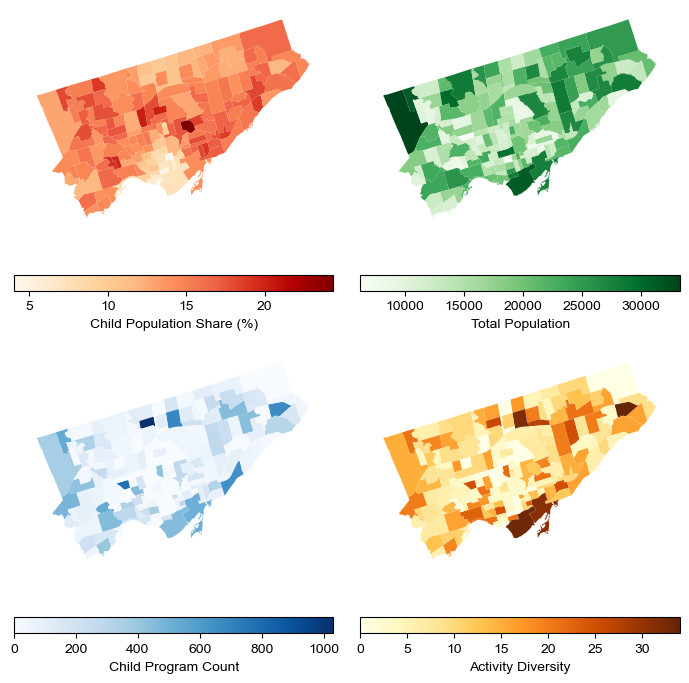

In [24]:
fig, axes = plt.subplots(2, 2, figsize=(7, 7))  

child_gdf.plot(
    column='Child Population Share',
    ax=axes[0, 0],
    legend=True,
    cmap='OrRd',
    legend_kwds={'label': "Child Population Share (%)", 'orientation': "horizontal"}
)
axes[0, 0].set_axis_off()

child_gdf.plot(
    column='Total Population',
    ax=axes[0, 1],
    legend=True,
    cmap='Greens',
    legend_kwds={'label': "Total Population", 'orientation': "horizontal"}
)
axes[0, 1].set_axis_off()

child_gdf.plot(
    column='total_course_count',
    ax=axes[1, 0],
    legend=True,
    cmap='Blues',
    legend_kwds={'label': "Child Program Count", 'orientation': "horizontal"}
)
axes[1, 0].set_axis_off()

child_gdf.plot(
    column='activity_diversity',
    ax=axes[1, 1],
    legend=True,
    cmap='YlOrBr',
    legend_kwds={'label': "Activity Diversity", 'orientation': "horizontal"}
)
axes[1, 1].set_axis_off()

plt.tight_layout()
plt.show()
fig.savefig("figures/child_population_program_map.pdf", bbox_inches='tight', dpi=300)

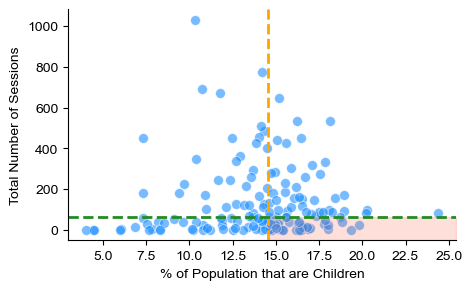

In [25]:
demand_median = child_gdf['Child Population Share'].median()
supply_median = child_gdf['total_course_count'].median()

fig, ax = plt.subplots(1, 1, figsize=(5, 3))
scatter = sns.scatterplot(
    data=child_gdf,
    ax=ax,
    x='Child Population Share',
    y='total_course_count',
    s=50,
    color='dodgerblue',
    edgecolor='white',
    alpha = 0.6
)

ax.axvline(demand_median, color='orange', linestyle='--', linewidth=2, label='Demand Median')
ax.axhline(supply_median, color='forestgreen', linestyle='--', linewidth=2, label='Supply Median')

xlim = plt.xlim()
ylim = plt.ylim()
ax.fill_between(
    x=[demand_median, xlim[1]],
    y1=ylim[0],
    y2=supply_median,
    color='tomato',
    alpha=0.2,
)
ax.set_xlim(xlim)
ax.set_ylim(ylim)
ax.set_xlabel('% of Population that are Children')
ax.set_ylabel('Total Number of Sessions')
set_splines_topright(ax)

plt.show()
fig.savefig("figures/child_population_program_scatter.pdf", bbox_inches='tight', dpi=300)

In [26]:
bottom_right_quadrant = child_gdf[
    (child_gdf['Child Population Share'] > demand_median) & 
    (child_gdf['total_course_count'] < supply_median)
]

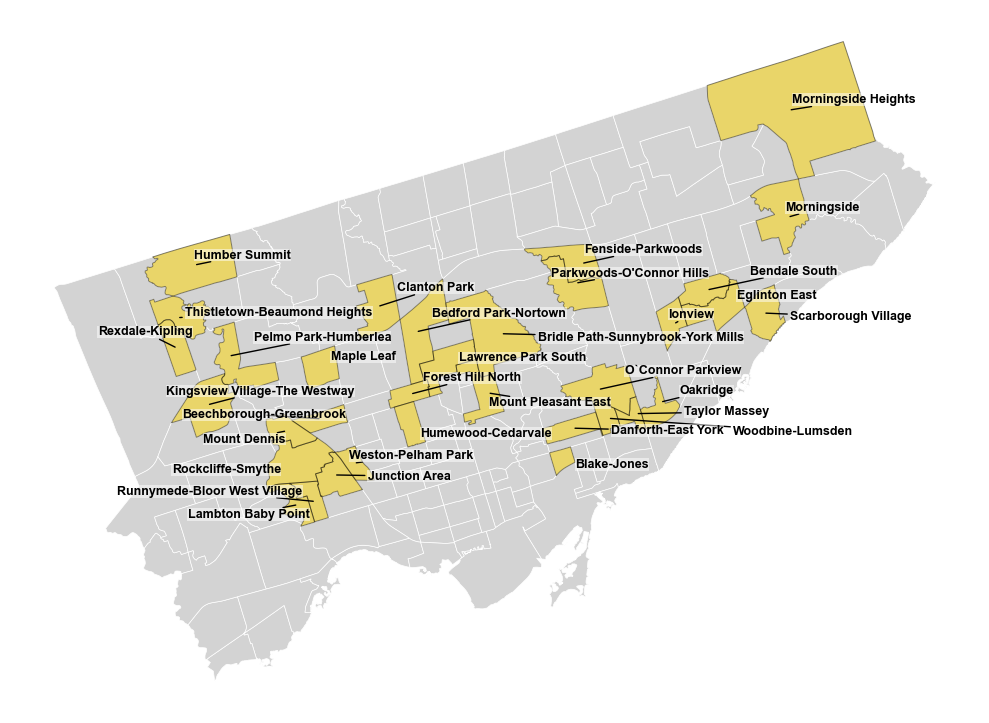

In [27]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

child_gdf.plot(
    ax=ax,
    color='lightgray', 
    edgecolor='white',
    linewidth=0.5
)

bottom_right_quadrant.plot(
    ax=ax,
    color='gold', 
    edgecolor='k',
    linewidth=0.7,
    alpha=.5
)

texts = []

for idx, row in bottom_right_quadrant.iterrows():
    centroid = row.geometry.representative_point()
    if centroid.is_empty:
        continue
    
    texts.append(
        ax.text(
            x=centroid.x,
            y=centroid.y,
            s=row['Neighbourhood Name'],
            fontdict={
                'fontsize': 9,
                'color': 'black',
                'weight': 'bold',
                'ha': 'center'
            },
            bbox=dict(facecolor='white', alpha=0.5, edgecolor='none', pad=0.2)
            )
    )

adjust_text(
    texts, 
    ax=ax,
    arrowprops=dict(arrowstyle='-', color='black', lw=1)
)
ax.set_axis_off()
plt.tight_layout()
plt.show()

fig.savefig("figures/child_population_program_map_neighbourhoods_to_target.pdf", bbox_inches='tight', dpi=300)

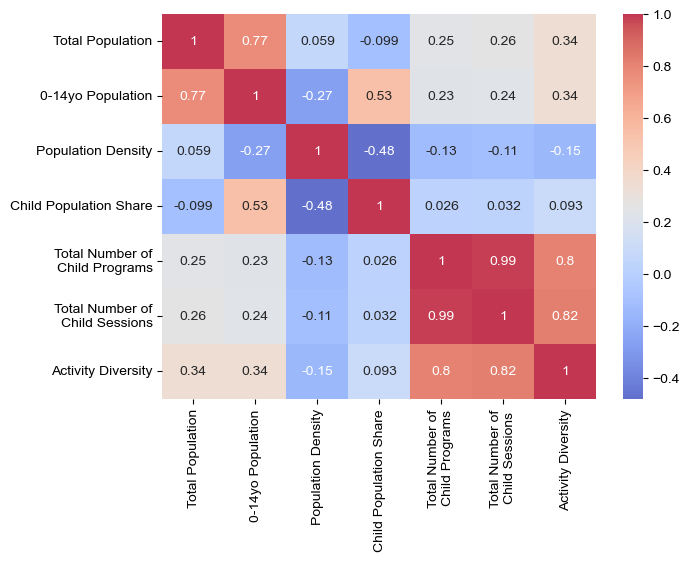

In [28]:
corr_matrix = child_gdf[[
    'Total Population', '0_14 years', 'population_density',
    'Child Population Share', 'total_course_count', 'total_sessions',
    'activity_diversity'
]].rename(columns={
    '0_14 years': '0-14yo Population',
    'population_density': 'Population Density',
    'total_course_count': 'Total Number of\nChild Programs',
    'total_sessions': 'Total Number of\nChild Sessions',
    'activity_diversity': 'Activity Diversity'
}).corr()

fig, ax = plt.subplots(1, 1, figsize=(7, 5))
sns.heatmap(corr_matrix, ax=ax, annot=True, cmap='coolwarm', alpha=0.8)
fig.savefig("figures/child_population_program_correlations.pdf", bbox_inches='tight', dpi=300)

#### Analysis for Equity of Program Distribution: NIA/Emerging and low income area

In [29]:
def summarize_all_by_address(registered_df: pd.DataFrame, dropin_df: pd.DataFrame) -> gpd.GeoDataFrame:
    """Summarize program data by full address from registered and drop-in datasets.

    This function combines registered and drop-in program data, aggregates 
    session counts and program counts by address, and collects spatial and 
    area metadata.

    Args:
      registered_df: DataFrame of registered programs with session info.
      dropin_df: DataFrame of drop-in programs with session info.

    Returns:
      A GeoDataFrame summarizing total sessions, program counts, and spatial info by address.
    """
    combined_df = pd.concat([registered_df, dropin_df], ignore_index=True)
    registered_sessions = (
        registered_df.groupby("ADDRESS_FULL")
        .agg(registered_total_sessions=("num_of_sessions", "sum"))
    )
    dropin_sessions = (
        dropin_df.groupby("ADDRESS_FULL")
        .agg(dropin_total_sessions=("num_of_sessions", "sum"))
    )
    program_count = (
        combined_df.groupby("ADDRESS_FULL")
        .agg(program_count=("Course_ID", "nunique"))
    )
    meta = (
        combined_df.groupby("ADDRESS_FULL")
        .agg(
            geometry=("geometry", "first"),
            AREA_SHORT_CODE=(
                "AREA_SHORT_CODE",
                lambda x: x.mode().iloc[0] if not x.mode().empty else x.iloc[0]
            )
        )
    )
    summary = (
        meta.join(program_count)
            .join(registered_sessions, how="left")
            .join(dropin_sessions, how="left")
            .fillna(0)
            .reset_index()
    )
    summary["total_sessions"] = summary["registered_total_sessions"] + summary["dropin_total_sessions"]
    summary[["registered_total_sessions", "dropin_total_sessions", "total_sessions", "program_count"]] = \
        summary[["registered_total_sessions", "dropin_total_sessions", "total_sessions", "program_count"]].astype(float)
    return gpd.GeoDataFrame(summary, geometry='geometry').set_crs(epsg=EPSG)

In [30]:
location_summary_df = summarize_all_by_address(registered_program_gdf, drop_in_gdf)

In [31]:
def remove_ticks(ax):
    """Remove x and y axis ticks from a matplotlib axis."""
    ax.set_xticks([])
    ax.set_yticks([])


def plot_locations(ax, location_summary_gdf, marker_key='program_count', marker_factor=0.1):
    """Plot program locations with marker sizes proportional to a key metric."""
    location_summary_gdf.plot(
        ax=ax,
        color='dodgerblue',
        markersize=location_summary_gdf[marker_key].astype(float) * marker_factor,
        alpha=0.8,
        zorder=2,
        edgecolor='#136abe'
    )


def set_splines(ax):
    """Hide all spines (borders) of a matplotlib axis."""
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)

In [32]:
def plot_multi_maps(location_summary_df, neighborhoods_gdf, configs):
    """
    Plot a 3xN grid of maps for different program types and neighborhood overlays.

    Args:
        location_summary_df: GeoDataFrame with program location summary.
        neighborhoods_gdf: GeoDataFrame with neighborhood demographic info.
        configs: List of dicts with keys:
                 - 'title': plot title
                 - 'key': column for marker size
                 - 'factor': marker size factor
    """
    n_cols = len(configs)
    fig, axes = plt.subplots(3, n_cols, figsize=(7 * n_cols, 15))
    if n_cols == 1:
        axes = axes.reshape(3, 1)

    # Common legend positions for colorbars
    legend_positions = [
        [0.92, 0.68, 0.01, 0.2],
        [0.92, 0.4, 0.01, 0.2],
        [0.92, 0.115, 0.01, 0.2],
    ]

    for col_idx, config in enumerate(configs):
        title = config['title']
        key = config.get('key', 'program_count')
        factor = config.get('factor', 0.1)

        # Row 1: Population Density
        ax = axes[0, col_idx]
        neighborhoods_gdf.plot(
            column='population_density',
            ax=ax,
            legend=True,
            cmap='Greens',
            edgecolor='white',
            legend_kwds={'label': 'Population Density (1,000 per km$^2$)', 'orientation': "vertical"},
            vmin=0, vmax=15,
            cax=fig.add_axes(legend_positions[0])
        )
        plot_locations(ax, location_summary_df, marker_key=key, marker_factor=factor)
        ax.set_title(f'{title} vs. Population Density',fontsize=19)
        remove_ticks(ax)
        set_splines(ax)

        # Row 2: Low Income
        ax = axes[1, col_idx]
        neighborhoods_gdf.plot(
            column='low income (%)',
            ax=ax,
            legend=True,
            cmap='Reds',
            edgecolor='white',
            legend_kwds={'label': 'Low-income Prevalence (%)', 'orientation': "vertical"},
            vmin=5, vmax=30,
            cax=fig.add_axes(legend_positions[1])
        )
        plot_locations(ax, location_summary_df, marker_key=key, marker_factor=factor)
        ax.set_title(f'{title} vs. Low Income %',fontsize=19)
        remove_ticks(ax)
        set_splines(ax)

        # Row 3: NIA Status
        ax = axes[2, col_idx]
        color_map = {
            'Not an NIA or Emerging Neighbourhood': 'lightgray',
            'Neighbourhood Improvement Area': 'lightpink',
            'Emerging Neighbourhood': '#FFD580'
        }
        neighborhoods_gdf.plot(
            ax=ax,
            color=neighborhoods_gdf['TSNS'].map(color_map),
            edgecolor='white',
        )
        plot_locations(ax, location_summary_df, marker_key=key, marker_factor=factor)
        ax.set_title(f'{title} vs. NIA Status',fontsize=19)
        remove_ticks(ax)
        set_splines(ax)

        if col_idx == n_cols - 1:
            legend_patches = [
                mpatches.Patch(color='lightgray', label='Not NIA or Emerging'),
                mpatches.Patch(color='lightpink', label='NIA'),
                mpatches.Patch(color='#FFD580', label='Emerging')
            ]
            program_handle = Line2D(
                [0], [0], marker='o', color='w',
                label='Program Locations',
                markerfacecolor='dodgerblue', markersize=10
            )
            ax.legend(handles=legend_patches + [program_handle], loc=(1.01, 0.1), frameon=False)

    plt.subplots_adjust(hspace=0.3, wspace=0.0)
    fig.savefig('figures/All_Program_Types_Map.pdf', bbox_inches='tight', dpi=300)
    plt.show()

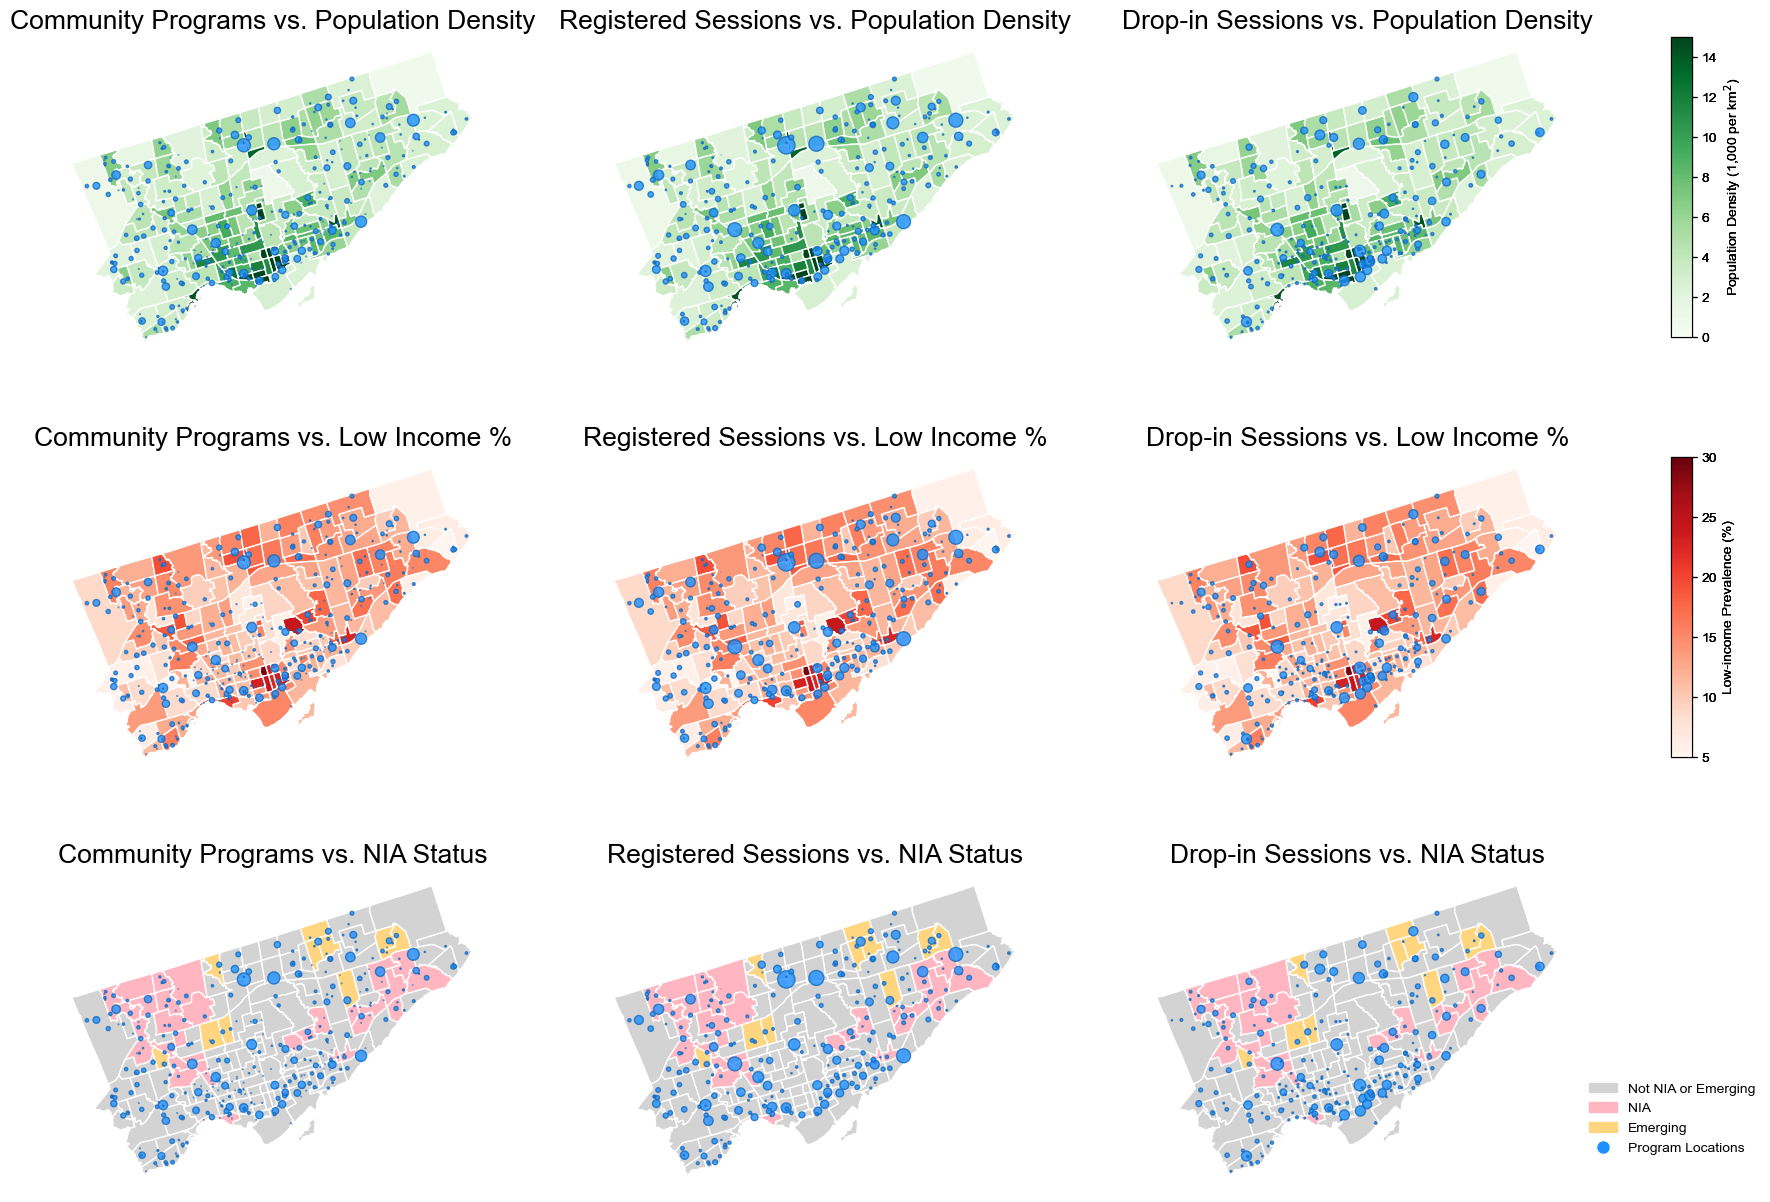

In [33]:
configs = [
    {'title': 'Community Programs'},
    {'title': 'Registered Sessions', 'key': 'registered_total_sessions', 'factor': 0.02},
    {'title': 'Drop-in Sessions', 'key': 'dropin_total_sessions', 'factor': 0.05},
]

plot_multi_maps(location_summary_df, demographics_gdf, configs)

#### Statistical Analysis

In [34]:
program_name_dict = {
    'program_count': 'Community Programs',
    'registered_total_sessions': 'Registered Sessions', 
    'dropin_total_sessions': 'Drop-in Sessions',
}

def get_metric_df(df: pd.DataFrame, count_key: str = 'program_count') -> pd.DataFrame:
    """Calculate program density metrics and map neighborhood types to simplified labels.

    Args:
      df: DataFrame with demographic and program count data.
      count_key: The column name representing program counts.

    Returns:
      DataFrame with added density columns and simplified neighborhood type labels.
    """
    df[f'{count_key}_density_1k'] = df[count_key] / df['Total Population'] * 1000
    df[f'{count_key}_density_1k_lowincome'] = df[f'{count_key}_density_1k'] * df['low income (%)'] / 100
    df['TSNS_NEW'] = df['TSNS'].map({
        'Not an NIA or Emerging Neighbourhood': 'Not NIA or\nEmerging',
        'Neighbourhood Improvement Area': 'NIA',
        'Emerging Neighbourhood': 'Emerging',
    })
    return df


def plot_one_violin(df: pd.DataFrame, ax, count_key: str, lowincome: bool = False):
    """Plot a violin plot with stripplot overlay for program density metrics by neighborhood type.

    Args:
      df: DataFrame with metrics and neighborhood labels.
      ax: Matplotlib Axes object to plot on.
      count_key: Base metric key used for density columns.
      lowincome: Whether to plot low-income adjusted density metric.
    """
    string = f'{count_key}_density_1k_lowincome' if lowincome else f'{count_key}_density_1k'
    ylabel_string = 'Low-Income\n' if lowincome else ''
    sns.violinplot(
        ax=ax,
        x='TSNS_NEW',
        y=string,
        data=df,
        palette='viridis',
        alpha=0.8,
    )
    sns.stripplot(
        ax=ax,
        x='TSNS_NEW',
        y=string,
        data=df,
        jitter=True,
        color='black',
        size=3,
        alpha=0.5 
    )
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_ylabel(f'{program_name_dict[count_key]}\nper 1000 {ylabel_string}People')
    ax.set_xlabel('')

In [35]:
location_stat_df = location_summary_df.merge(
    demographics_df[['AREA_SHORT_CODE', 'Total Population', 'low income (%)', 'TSNS']],
    how='left',
    left_on='AREA_SHORT_CODE',
    right_on='AREA_SHORT_CODE'
)

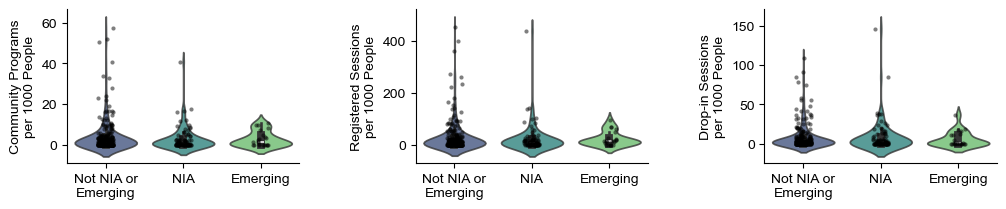

In [36]:
fig, axs = plt.subplots(1, 3, figsize=(12, 2))
count_keys = ['program_count','registered_total_sessions', 'dropin_total_sessions']
for ax, count_key in zip(axs, count_keys):
    df = get_metric_df(location_stat_df, count_key=count_key)
    plot_one_violin(df, ax, count_key)
plt.subplots_adjust(wspace=0.5)
fig.savefig("figures/nia_analysis_violin.pdf", bbox_inches='tight', dpi=300)

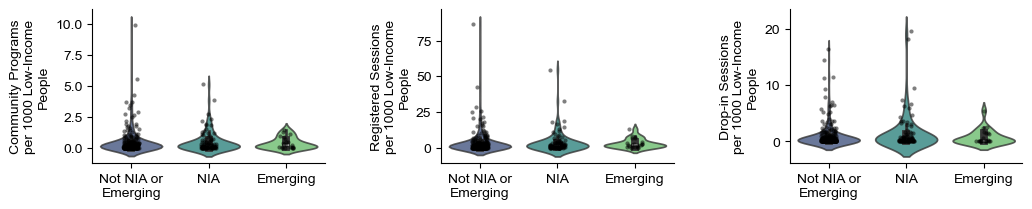

In [37]:
fig, axs = plt.subplots(1, 3, figsize=(12, 2))
for ax, count_key in zip(axs, count_keys):
    df = get_metric_df(location_stat_df, count_key=count_key)
    plot_one_violin(df, ax, count_key, lowincome=True)
plt.subplots_adjust(wspace=0.5)
fig.savefig("figures/nia_analysis_violin_lowincome.pdf", bbox_inches='tight', dpi=300)

In [38]:
class_name_dict = {
    'Not an NIA or Emerging Neighbourhood': 'Not NIA or Emerging',
    'Neighbourhood Improvement Area': 'NIA',
    'Emerging Neighbourhood': 'Emerging',
}
for population in ['', '_lowincome']:
    for count_key in count_keys:
        column = f'{count_key}_density_1k{population}'
        print(count_key, population)
        means = location_stat_df.groupby('TSNS').agg(program_density=(column, 'mean'))
        stds = location_stat_df.groupby('TSNS').agg(program_density=(column, 'std'))
        strings = [f'{mean:.2f} ± {std:.2f}' for mean, std in zip(means.values.squeeze(), stds.values.squeeze())]
        for class_, string in zip(means.index, strings):
            print(class_name_dict[class_],':', string)
        print()

program_count 
Emerging : 3.24 ± 3.78
NIA : 3.11 ± 5.67
Not NIA or Emerging : 4.19 ± 8.16

registered_total_sessions 
Emerging : 24.93 ± 27.37
NIA : 23.91 ± 53.37
Not NIA or Emerging : 29.47 ± 60.70

dropin_total_sessions 
Emerging : 6.12 ± 9.62
NIA : 8.74 ± 19.60
Not NIA or Emerging : 8.15 ± 16.04

program_count _lowincome
Emerging : 0.40 ± 0.47
NIA : 0.51 ± 0.86
Not NIA or Emerging : 0.46 ± 0.99

registered_total_sessions _lowincome
Emerging : 3.08 ± 3.37
NIA : 3.83 ± 7.59
Not NIA or Emerging : 3.21 ± 7.65

dropin_total_sessions _lowincome
Emerging : 0.80 ± 1.35
NIA : 1.50 ± 3.25
Not NIA or Emerging : 0.99 ± 2.19



In [39]:
# ANOVA to see if averages are different between 3 groups
for population in ['', '_lowincome']:
    for count_key in count_keys:
        column = f'{count_key}_density_1k{population}'
        grouped_data = [location_stat_df[column][location_stat_df['TSNS'] == cls] for cls in location_stat_df['TSNS'].unique()]
        f_statistic, p_value = scipy.stats.f_oneway(*grouped_data)
        print(f"{column} P-value: {p_value:.4f}")

program_count_density_1k P-value: 0.4671
registered_total_sessions_density_1k P-value: 0.7190
dropin_total_sessions_density_1k P-value: 0.8047
program_count_density_1k_lowincome P-value: 0.8774
registered_total_sessions_density_1k_lowincome P-value: 0.7885
dropin_total_sessions_density_1k_lowincome P-value: 0.2047


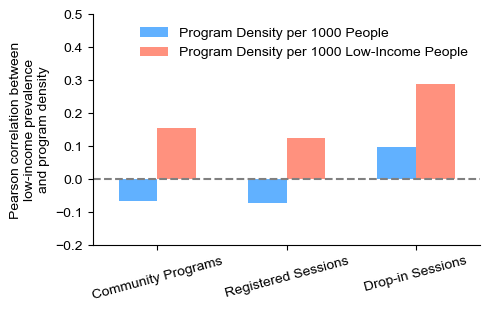

In [40]:
population_corrs = []
for population in ['', '_lowincome']:
    corrs = []
    for count_key in count_keys:
        column = f'{count_key}_density_1k{population}'
        corr = scipy.stats.pearsonr(
            location_stat_df['low income (%)'].astype(float),
            location_stat_df[column].astype(float)
        ).statistic
        corrs.append(corr)
    population_corrs.append(corrs)
    
x = np.arange(len(count_keys))
width = 0.3
fig, ax = plt.subplots(1, 1, figsize=(5, 3))
ax.bar(x - width / 2, population_corrs[0], width=width, color='dodgerblue', alpha=0.7, label='Program Density per 1000 People')
ax.bar(x + width / 2, population_corrs[1], width=width, color='tomato', alpha=0.7, label='Program Density per 1000 Low-Income People')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.hlines(xmin=-0.5, xmax=len(x)-0.5, y=0, color='gray', linestyle='--')
ax.set_xlim([-0.5, len(x)-0.5])
ax.set_ylim([-0.2, 0.5])
ax.set_xticks(x, [program_name_dict[name] for name in count_keys], rotation=15)
ax.set_ylabel('Pearson correlation between\nlow-income prevalence\nand program density')
plt.legend(frameon=False)
fig.savefig("figures/nia_analysis_correlations.pdf", bbox_inches='tight', dpi=300)